# [たんぽぽ]表面付着物の分類

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive
import os
os.chdir('/content/drive/MyDrive/Data_HonokaKiryu/Data3')

Mounted at /content/drive
/content/drive/MyDrive


In [2]:
import tensorflow as tf

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import re
import pickle

## データの読み込み

In [5]:
#画像サイズがが704x480 #88x60
batch_size = 12
epochs = 18
IMG_HEIGHT = 224
IMG_WIDTH = 224

In [6]:
# データの保蔵先
SAVE_DATE_DIR_PATH = "/content/drive/MyDrive/Data_HonokaKiryu/Data3"
train_dir = "/content/drive/MyDrive/Data_HonokaKiryu/Data3/TrainingData3"
test_dir = "/content/drive/MyDrive/Data_HonokaKiryu/Data3/TestData3"

train_sputter_dir = os.path.join(train_dir, '1Sputter') #学習用のSputterのディレクトリ
train_fiber_dir = os.path.join(train_dir, '2Fiber') #学習用のFiberのディレクトリ
train_block_dir = os.path.join(train_dir, '3Block') #学習用のBlockのディレクトリ
train_bar_dir = os.path.join(train_dir, '4Bar') #学習用のBarのディレクトリ
train_agfragment_dir = os.path.join(train_dir, '5AGFragment/1AGFragment') #学習用のAGFragmentのデェレクトリ
#/content/drive/MyDrive/Data_HonokaKiryu/Data3/TestData3/5AGFragment/1AGFragment

test_sputter_dir = os.path.join(test_dir, '1Sputter') #テスト用のSputterのデェレクトリ
test_fiber_dir = os.path.join(test_dir, '2Fiber') #テスト用のFiberのデェレクトリ
test_block_dir = os.path.join(test_dir, '3Block') #テスト用のBlockのデェレクトリ
test_bar_dir = os.path.join(test_dir, '4Bar') #テスト用のBarのデェレクトリ
test_agfragment_dir = os.path.join(test_dir, '5AGFragment/1AGFragment') #テスト用のAGFragmentのデェレクトリ

## データの理解

In [7]:
num_sputter_tr = (len(os.listdir(train_sputter_dir)) - 1) #.DS_Storeを除く
num_fiber_tr = (len(os.listdir(train_fiber_dir)) - 1)
num_block_tr = (len(os.listdir(train_block_dir)) - 1)
num_bar_tr = (len(os.listdir(train_bar_dir)) - 1)
num_agfragment_tr = (len(os.listdir(train_agfragment_dir)) - 1)

num_sputter_ts = (len(os.listdir(test_sputter_dir)) - 1)
num_fiber_ts = (len(os.listdir(test_fiber_dir)) - 1)
num_block_ts = (len(os.listdir(test_block_dir)) - 1)
num_bar_ts = (len(os.listdir(test_bar_dir)) - 1)
num_agfragment_ts = (len(os.listdir(test_agfragment_dir)) - 1)

total_train = num_sputter_tr + num_fiber_tr + num_block_tr + num_bar_tr + num_agfragment_tr
total_test = num_sputter_ts + num_fiber_ts + num_block_ts + num_bar_ts + num_agfragment_ts

In [8]:
print('total training sputter images:', num_sputter_tr)
print('total training fiber images:', num_fiber_tr)
print('total training block images:', num_block_tr)
print('total training bar images:', num_bar_tr)
print('total training agfragment images:', num_agfragment_tr)

print('total test sputter images:', num_sputter_ts)
print('total test fiber images:', num_fiber_ts)
print('total test block images:', num_block_ts)
print('total test bar images:', num_bar_ts)
print('total test agfragment images:', num_agfragment_ts)
print("--")
print('Total training images:', total_train)
print('Total test images:', total_test)

total training sputter images: 48
total training fiber images: 79
total training block images: 53
total training bar images: 63
total training agfragment images: 20
total test sputter images: 21
total test fiber images: 33
total test block images: 23
total test bar images: 24
total test agfragment images: 5
--
Total training images: 263
Total test images: 106


## データの準備

In [9]:
# train_image_generator = ImageDataGenerator(rescale=1./255)
# validation_image_generator = ImageDataGenerator(rescale=1./255)

In [10]:
# train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
#                                                            directory=train_dir,
#                                                            shuffle=True,
#                                                            target_size=(IMG_HEIGHT, IMG_WIDTH),
#                                                            class_mode='binary')

In [11]:
# val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
#                                                          directory=validation_dir,
#                                                          target_size=(IMG_HEIGHT, IMG_WIDTH),
#                                                          class_mode='binary')

## データ拡張(Data augmentation)

In [12]:
image_gen_train = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5,
                    zca_whitening=True, #ZCA ZCA whitening
                    validation_split=0.2 #検証用データセット分割
)
total_val = total_train * 0.2

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:337: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


In [13]:
train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary',
                                                     subset='training', #train
                                                     )

val_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary',
                                                     subset='validation' #validation
                                                     )

Found 221 images belonging to 5 classes.
Found 52 images belonging to 5 classes.


In [14]:
print(train_data_gen.image_shape)
print(train_data_gen.class_indices)

(224, 224, 3)
{'1Sputter': 0, '2Fiber': 1, '3Block': 2, '4Bar': 3, '5AGFragment': 4}


### 続き

In [15]:
image_gen_val = ImageDataGenerator(rescale=1./255)

In [16]:
test_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                   directory=test_dir,
                                                   target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                   class_mode='binary')

Found 111 images belonging to 5 classes.


## 学習用画像の可視化

In [17]:
sample_training_images, _ = next(train_data_gen)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:739: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


In [18]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

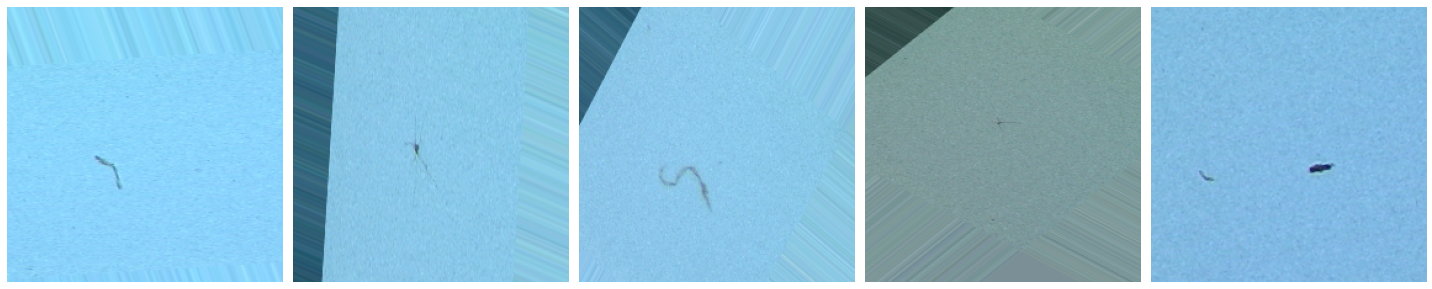

In [19]:
plotImages(sample_training_images[:5])

## モデルの構築

In [20]:
# model = Sequential([
#     Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
#     MaxPooling2D(),
#     Dropout(0.1),
#     Conv2D(32, 3, padding='same', activation='relu'),
#     MaxPooling2D(),
#     Conv2D(64, 3, padding='same', activation='relu'),
#     MaxPooling2D(),
#     Dropout(0.1),
#     Flatten(),
#     Dense(512, activation='relu'),
#     Dense(1, activation='sigmoid')
# ])
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

vgg16 = VGG16(include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
model = Sequential(vgg16.layers)

for layer in model.layers[:15]:
    layer.trainable = False

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

58900480/58889256 [==============================] - 0s 0us/step


### モデルのコンパイル

In [21]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

## モデルの学習

In [22]:
history = model.fit_generator(
    train_data_gen,
    #steps_per_epoch=(total_train) // batch_size,
    steps_per_epoch=10,
    epochs=epochs,
    #validation_split=0.2,
    validation_data=val_data_gen,
    #alidation_steps=(int(total_val)) // batch_size,
    validation_steps=4,
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:739: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/18
10/10 [==============================] - 121s 11s/step - loss: -5266.8906 - accuracy: 0.2920 - val_loss: -57854.5430 - val_accuracy: 0.2500
Epoch 2/18
10/10 [==============================] - 33s 3s/step - loss: -285311.5938 - accuracy: 0.2833 - val_loss: -837043.0000 - val_accuracy: 0.2708
Epoch 3/18
10/10 [==============================] - 15s 1s/step - loss: -2061786.0000 - accuracy: 0.2832 - val_loss: -4398522.5000 - val_accuracy: 0.3125
Epoch 4/18
10/10 [==============================] - 8s 734ms/step - loss: -9495216.0000 - accuracy: 0.2743 - val_loss: -19136694.0000 - val_accuracy: 0.2917
Epoch 5/18
10/10 [==============================] - 7s 742ms/step - loss: -31783714.0000 - accuracy: 0.3000 - val_loss: -58058956.0000 - val_accuracy: 0.2500
Epoch 6/18
10/10 [==============================] - 4s 448ms/step - loss: -68542784.0000 - accuracy: 0.3186 - val_loss: -119917400.0000 - val_accuracy: 0.2917
Epoch 7/18
10/10 [==============================] - 3s 293ms/step - l

In [23]:
print(total_train // batch_size)
print(total_val)
print(int(total_val) // batch_size)

21
52.6
4


# テスト用データセットで検証

In [24]:
test_loss, test_acc = model.evaluate(test_data_gen,
                                     batch_size=batch_size,
                                     verbose=1,
                                     )

10/10 [==============================] - 71s 8s/step - loss: -24350943232.0000 - accuracy: 0.2973


In [25]:
print("Test Accuracy and Loss")
print("-----")
print("test_loss: ",test_loss)
print("test_acc: ", test_acc)

Test Accuracy and Loss
-----
test_loss:  -24350943232.0
test_acc:  0.29729729890823364


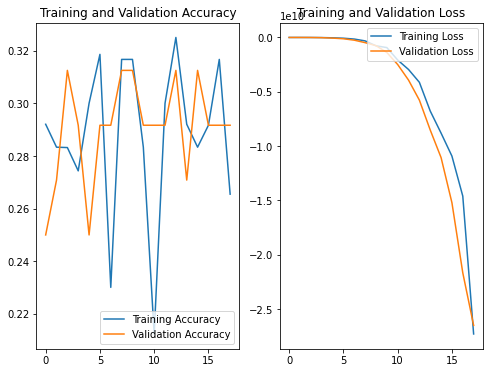

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()